In [1]:
%pylab inline
%load_ext autoreload

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import json
from collections import defaultdict
from functools import reduce
import copy
import numpy as np
import random

import datetime as dt
pd.set_option('display.max_columns', 500)

import time

from collections import defaultdict
from collections import Counter

from functools import lru_cache
import seaborn as sns

from scipy.special import expit
from functools import partial
from multiprocessing import Pool
from tqdm import tqdm

import csv

In [3]:
class agent():
    def __init__(self, number, coop, payoff=0):
        self.number = number
        self.coop = coop
        self.payoff = payoff

    def set_coop(self, coop):
        self.coop = coop

        
class circle():
    def __init__(self, n, p, w, b, c = 1, all_coop = True):
        self.b = b
        self.c = c

        self.p = p
        self.n = n
        self.w = w
        self.arr = [agent(i, all_coop) for i in range(n)]
        
        self.global_coop = n if all_coop else 0

        
    def access(self, index):
        return self.arr[index%self.n]
    
    def accessIndex(self, index):
        return index%self.n

    def choose_one_rand(self):
        index = np.random.choice(self.n, 1)[0]
        return self.access(index)
    
    def choose_index_rand(self):
        return random.randrange(0, self.n)
    
    def flip_agent(self, index_flipped):
        current = self.access(index_flipped)
        current.coop = not current.coop
        self.global_coop = sum([i.coop for i in self.arr])
        
 

    def count_coop(self):
        return sum([i.coop for i in self.arr])


    def make_action(self):
        
        self.update_all_payoff()
        index = self.choose_index_rand()
        
        if random.random() > self.p:
            self.action_local_on(index)
        else:
            self.action_global_on(index)
        
        self.reset_all_payoff()
        

    def action_local_on(self, index): 
        
        ags =  [self.access(index-1), self.access(index), self.access(index+1)]
        defe = [ag.payoff for ag in ags if ag.coop == False]
        coope = [ag.payoff for ag in ags if ag.coop == True]
        
        if len(defe)==0 or len(coope)==0: 
            return
       
        avg_def = np.mean(defe) * self.w 
        avg_coop = np.mean(coope) * self.w
        logitDef = expit(avg_def) / (expit(avg_def) + expit(avg_coop))       
        
        if random.random() < logitDef:
            self.access(index).coop = False
        else:
            self.access(index).coop = True
            
        self.global_coop = sum([i.coop for i in self.arr])
     
         

    def action_global_on(self, index):
        choosen_as_rand = self.choose_one_rand()
        me = self.access(index)
        
        if me.coop == choosen_as_rand.coop:
            return
        
        me_score = me.payoff * self.w 
        other_score = choosen_as_rand.payoff * self.w 
        
        logit_other_score = expit(other_score) / (expit(other_score) + expit(me_score))       
        
        if random.random() < logit_other_score:
            me.coop = choosen_as_rand.coop
            self.global_coop = sum([i.coop for i in self.arr])
        

    def update_all_payoff(self):
        for a in self.arr:
            if a.coop:
                self.access(a.number + 1).payoff += self.b
                self.access(a.number - 1).payoff += self.b
                a.payoff -= 2 * self.c
            else:
                pass
           
        
    def reset_all_payoff(self):
        for a in self.arr:
            a.payoff = 0

In [4]:
def _runModel(i, n, p, w, b, all_coop):
    random.seed(int(time.time() + i))
    c = circle(n=n, p=p, w=w, b=b, all_coop=all_coop)
    c.flip_agent(0)
    
    n_iter = 0
    while True:
        n_iter += 1
        if c.global_coop == 0 or c.global_coop == c.n: 
            break

        c.make_action()

    return all([i.coop != all_coop  for i in c.arr]), n_iter

In [5]:
def runModel(iteration, n, p, w, b, all_coop):
    nRun = iteration
    
    __runModel = partial(_runModel, n=n, p=p, w=w, b=b, all_coop=all_coop)

    with Pool(4) as p:
          r, n_iters = zip(*list(tqdm(p.imap(__runModel, range(nRun)), total=nRun)))
    
    fix = sum(r)/len(r)
    
    return fix, n_iters, r

In [6]:
ps = [0, 0.4, 1] #np.arange(0, 1.1, 0.1)
coops = [runModel(1000, n=30, p=p, w=0.01, b=5, all_coop=False) for p in ps]

100%|██████████| 1000/1000 [00:02<00:00, 392.72it/s]


ValueError: `dataset` input should have multiple elements.

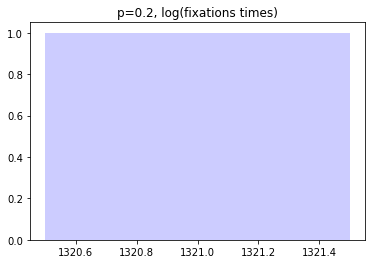

In [138]:
indice_tmp = 0

for p_t in ps:
    
    tmp_blue = list()
    tmp_red = list()
    
    indice = 0
    for item in coops[indice_tmp][2]:
        if item:
            tmp_blue.append(coops[indice_tmp][1][indice])
        else:
            tmp_red.append(coops[indice_tmp][1][indice])
        indice += 1

    plt.title('p={}, log(fixations times)'.format(round(p_t, 3)))
    sns.distplot(tmp_blue, kde=False, color='blue', hist_kws = {"alpha":0.2}, label='fixation to coop')
    sns.distplot(tmp_red, kde=False, color='red', hist_kws = {"alpha":0.2}, label='no fixation to coop')
    
    #plt.yscale('log')
    #plt.xscale('log')

    plt.legend()
    plt.tight_layout()

    plt.ylabel('number of simulations')
    plt.xlabel('time')

    plt.tight_layout()

    plt.savefig('time_distributions_p_{}.png'.format(round(p_t, 3)), format='png', dpi=800)
    
    indice_tmp += 1
    plt.close()

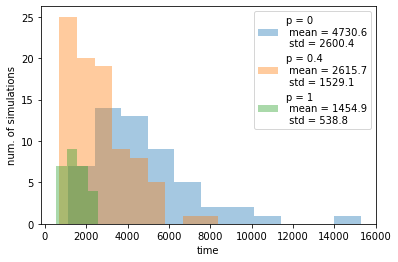

In [25]:
indice_lista = 0

means = list()
stds = list()
sims = list()

for lista in coops:
    tmp = list()
    indice = 0
    
    
    for item in lista[2]:
        if item:
            tmp.append(lista[1][indice])
        indice += 1
    
    if 1:# indice_lista == 0 or indice_lista == 10:
        #print('sim that reach full coop (p={}) = {}'.format(round(ps[indice_lista], 3), len(tmp)))
        sims.append(len(tmp))
        sns.distplot(tmp, kde=False, label='p = {}\n mean = {}\n std = {}'.format(round(ps[indice_lista], 2), round(np.mean(tmp), 1), round(np.std(tmp), 1)), kde_kws={'alpha':0.2})
        
        means.append(np.mean(tmp))
        stds.append(np.std(tmp))

    plt.legend(loc='best')
    plt.xlabel('time')
    plt.ylabel('num. of simulations')
    
    indice_lista += 1

plt.savefig('fixation_distributions.png', format='png', dpi=800)

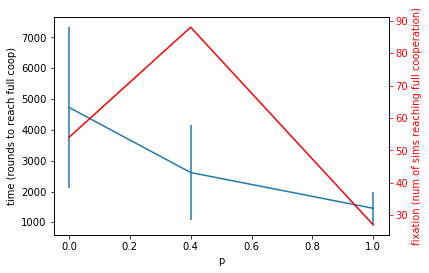

In [36]:
ax1 = plt.plot()

plt.errorbar(ps, means, stds)
#plt.fill_between(ps, means-stds, means+stds)

plt.xlabel('p')
plt.ylabel('time (rounds to reach full coop)')

ax2 = plt.gca().twinx() 
#plt.scatter(ps, sims, c='red')
plt.plot(ps, sims, c='red')
plt.ylabel('fixation (num of sims reaching full cooperation)', color='r')
ax2.tick_params(axis='y', colors='red')

Text(0, 0.5, '$cv²= \\sigma² / mean}$')

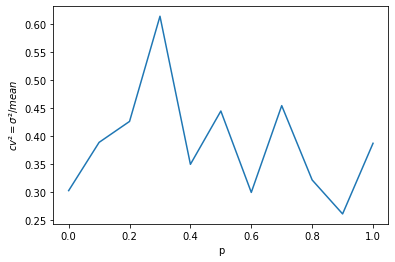

In [30]:
cvs = [stds[i]**2/means[i]**2 for i in range(len(ps))]
plt.plot(ps, cvs)
plt.xlabel('p')
plt.ylabel('$cv²= \sigma² / mean}$')

100%|██████████| 5000/5000 [00:02<00:00, 1942.90it/s]


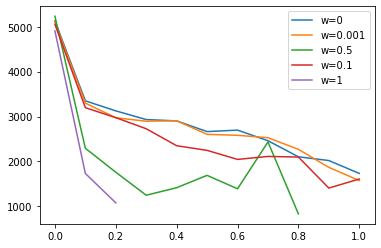

In [40]:
ws = [0, 0.001, 0.5, 0.1, 1]
ps = np.arange(0, 1.1, 0.1)

means_total = list()

for w in ws:
    means=list()
    stds=list()
    
    coops = [runModel(5000, n=30, p=p, w=w, b=5, all_coop=False) for p in ps]
        
    for lista in coops:
        tmp = list()
        
        indice = 0
        for item in lista[2]:
            if item: tmp.append(lista[1][indice])
            indice+=1
            
        means.append(np.mean(tmp))
    
    means_total.append(means)
    
    plt.plot(ps, means, label='w={}'.format(w))

plt.legend(loc='best')#, bbox_to_anchor=(1, 0.5))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


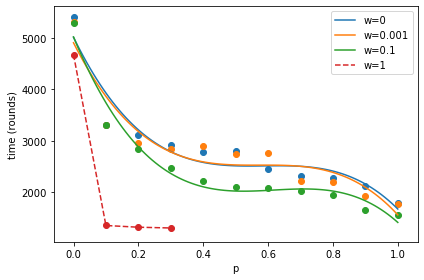

In [86]:
i = 0
for item in means_total[:-1]:
    plt.scatter(ps, item)
    #plt.plot(ps, item, '--')
    
    p = np.poly1d(np.polyfit(ps, item, 3))
    xp = np.linspace(0, 1, 100)
    plt.plot(xp, p(xp), label='w={}'.format(ws[i]))
    i += 1

    
plt.scatter(ps, means_total[-1])
plt.plot(ps, means_total[-1], '--', label='w={}'.format(ws[-1]))
#p = np.poly1d(np.polyfit(ps[:3], means_total[-1][:3] + means_total[-1][3]*6, 2))
#xp = np.linspace(0, 0.3, 100)
#plt.plot(xp, p(xp), label='w={}'.format(ws[-1]))
   
plt.legend(loc='best')
plt.xlabel('p')
plt.ylabel('time (rounds)')
#plt.title('fixation times for different selection strength')

plt.tight_layout()

plt.savefig('fixation_times_Fc.eps', format='eps', dpi=5000)

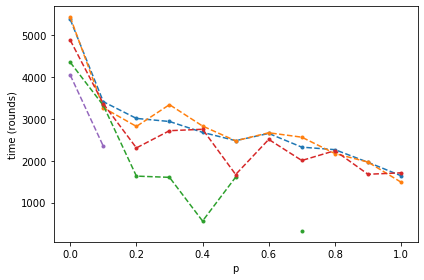

In [39]:
i = 0
for item in means_total:
    plt.plot(ps, item, linestyle='--', marker='.')
    i += 1
    

#plt.legend(loc='best')
plt.xlabel('p')
plt.ylabel('time (rounds)')

plt.tight_layout()

plt.savefig('fixation_times_Fc.eps', format='eps', dpi=500)

In [79]:
with open('data_sims_times.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerows(coops)
f.close()

# TIME
Extra simulations

Fixing p=0.1 and letting b move between 3 and 5

100%|██████████| 1000/1000 [00:01<00:00, 884.24it/s]


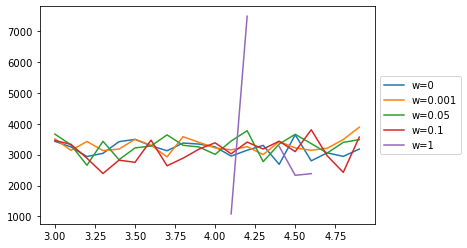

In [142]:
ws = [0, 0.001, 0.05, 0.1, 1]
bs = np.arange(3, 5, 0.1)

means_total = list()

for w in ws:
    means=list()
    stds=list()
    
    coops = [runModel(1000, n=30, p=0.1, w=w, b=b, all_coop=False) for b in bs]
        
    for lista in coops:
        tmp = list()
        
        indice = 0
        for item in lista[2]:
            if item: tmp.append(lista[1][indice])
            indice+=1
            
        means.append(np.mean(tmp))
    
    means_total.append(means)
    
    plt.plot(bs, means, label='w={}'.format(w))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

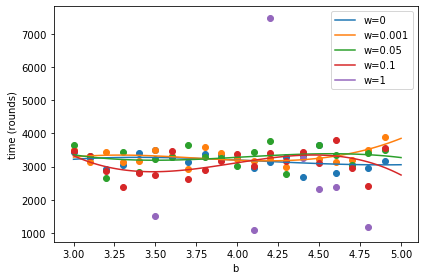

In [146]:
i = 0
for item in means_total[:]:
    plt.scatter(bs, item)
    #plt.plot(ps, item, '--')
    
    p = np.poly1d(np.polyfit(bs, item, 3))
    xp = np.linspace(3, 5, 100)
    plt.plot(xp, p(xp), label='w={}'.format(ws[i]))
    i += 1


#plt.scatter(bs, means_total[-1])
#plt.plot(bs, means_total[-1], '--', label='w={}'.format(ws[-1]))

plt.legend(loc='best')
plt.xlabel('b')
plt.ylabel('time (rounds)')

plt.tight_layout()

#plt.savefig('fixation_times_Fc_fixedP.eps', format='eps', dpi=5000)

100%|██████████| 1000/1000 [00:04<00:00, 246.01it/s]

fc [[13, 0, 0, 0, 0, 0]]
fd [[62, 202, 225, 167, 158, 89]]
[[0.20967742 0.         0.         0.         0.         0.        ]]



100%|██████████| 1000/1000 [00:05<00:00, 166.79it/s]


fc [[10, 2, 0, 1, 0, 0]]
fd [[67, 203, 179, 165, 141, 68]]
[[0.14925373 0.00985222 0.         0.00606061 0.         0.        ]]


100%|██████████| 1000/1000 [00:03<00:00, 255.56it/s]


fc [[10, 0, 0, 0, 0, 0]]
fd [[73, 174, 194, 184, 140, 77]]
[[0.1369863 0.        0.        0.        0.        0.       ]]


100%|██████████| 1000/1000 [00:04<00:00, 248.30it/s]

fc [[11, 0, 0, 0, 0, 0]]
fd [[71, 192, 192, 168, 160, 65]]
[[0.15492958 0.         0.         0.         0.         0.        ]]


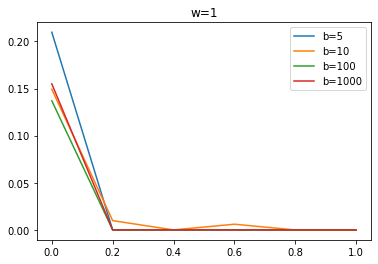

In [6]:
p_star_total = list()
store_dif_divs = []

bbs = [5, 10, 100, 1000]

for b in bbs:
    
    ws = [1]
    ps = np.arange(0, 1.2, 0.2)

    means_total = list()
    sims_total = list()

    for w in ws:
        means=list()
        stds=list()
        sims = list()

        coops = [runModel(1000, n=30, p=p, w=w, b=b, all_coop=False) for p in ps]

        for lista in coops:
            tmp = list()
            indice = 0

            for item in lista[2]:
                if item: tmp.append(lista[1][indice])
                indice += 1

            sims.append(len(tmp))

        sims_total.append(sims)


    means_total = list()
    sims_total2 = list()

    for w in ws:
        means=list()
        stds=list()
        sims = list()

        coops = [runModel(1000, n=30, p=p, w=w, b=b, all_coop=True) for p in ps]

        for lista in coops:
            tmp = list()
            indice = 0

            for item in lista[2]:
                if item: tmp.append(lista[1][indice])
                indice += 1

            sims.append(len(tmp))

        sims_total2.append(sims)


    print(f'fc {sims_total}')
    print(f'fd {sims_total2}')
    
    division = np.divide(sims_total, sims_total2)
    
    print(division)
    
    #p = np.poly1d(np.polyfit(ps, division[0], 5))
    #xp = np.linspace(0, 1, 100)

    resta = 1/30 - division
    #if all(resta < 0):
    #    p_star = 0
    #else:
    #    val = next(obj for obj in resta if obj<0)
    #    p_str = numpy.where(resta==val)


    #p_star_total.append(p_star)
    store_dif_divs.append(division[0])
    
    
    
    
    
idx = 0
for bt in bbs:
    plt.plot(ps, store_dif_divs[idx], label='b={}'.format(bt))
    idx += 1
plt.title(f'w={ws[0]}')
plt.legend()

In [22]:
plt.plot(ps, division[0])
plt.title(f'w={ws[0]}')

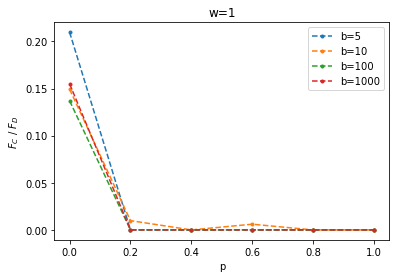

In [10]:
idx = 0
for bt in bbs:
    plt.plot(ps, store_dif_divs[idx], label='b={}'.format(bt), linestyle='--', marker='.')
    idx += 1
plt.title(f'w={ws[0]}')
plt.legend()

plt.ylabel('$F_C\ /\ F_D$')
plt.xlabel('p')

plt.savefig('ratios w={}.png'.format(ws[0]), format='png', dpi=800)

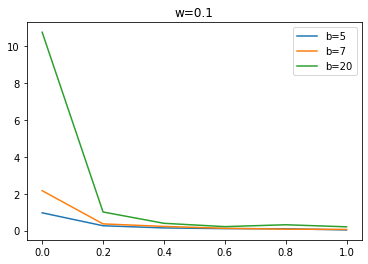

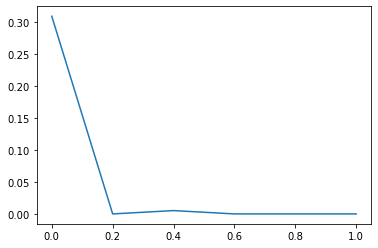

In [82]:
ws = [0.01]
ps = np.arange(0, 1.1, 0.1)

means_total = list()
sims_total2 = list()

for w in ws:
    means=list()
    stds=list()
    sims = list()
    
    coops = [runModel(1000, n=30, p=p, w=w, b=5, all_coop=True) for p in ps]
        
    for lista in coops:
        tmp = list()
        indice = 0

        for item in lista[2]:
            if item: tmp.append(lista[1][indice])
            indice += 1

        sims.append(len(tmp))

    sims_total2.append(sims)

100%|██████████| 1000/1000 [00:04<00:00, 212.76it/s]


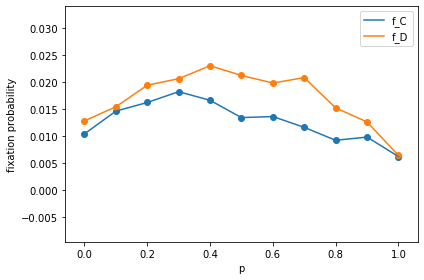

In [83]:
i = 0

for item in sims_total:
    item = np.true_divide(item, 5000)
    plt.scatter(ps, item)
    plt.plot(ps, item, label='f_C')
    i += 1

for item in sims_total2:
    item = np.true_divide(item, 5000)
    plt.scatter(ps, item)
    plt.plot(ps, item, label='f_D')
    i += 1
    
#plt.hlines(1/30, 0, 1, label='well-mixed')
plt.xlabel('p')
plt.ylabel('fixation probability')
#plt.title('fixation prob. for different selection strengths')

plt.legend(loc='best')
plt.tight_layout()

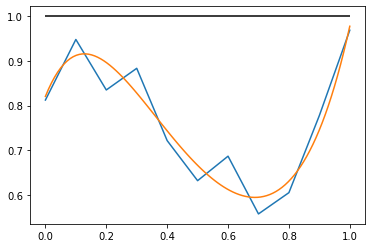

In [84]:
division = np.divide(sims_total, sims_total2)
plt.plot(ps, division[0])

plt.hlines(1, 0, 1)

p = np.poly1d(np.polyfit(ps, division[0], 5))
xp = np.linspace(0, 1, 100)
plt.plot(xp, p(xp))

In [85]:
resta = 1/30 - division
if all(resta < 0):
    p_star = 0
else:
    val = next(obj for obj in resta if obj<0)
    p_str = numpy.where(resta==val)

In [86]:
p_star_total.append(p_star)

In [15]:
p_star_total

[0]

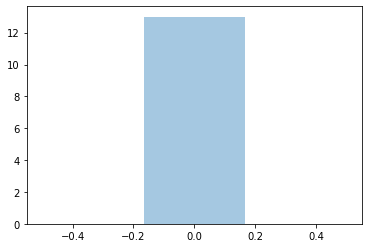

In [94]:
sns.distplot(p_star_total, kde=False)

Store the values of p* for different b. w=0.01

In [ ]:
bss = [0, 2, 5, 50, 1000, 10e6]
p_stars = [0, 0, 0, 0, 0, 0]